<a href="https://colab.research.google.com/github/pujab21/breast-cancer-ml-models/blob/main/SEER_breast_cancer_classification_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize
!pip install xgboost
!pip install scikit-survival
!pip install utils
!pip install lifelines
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=10a114be3a091bec9906504e1876a3ac245abe8f72a17b624acb9f81af7d469c
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import xgboost as xgb
import pickle
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.svm import SVC,LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score, ConfusionMatrixDisplay,roc_curve, auc, mean_squared_error, make_scorer,  matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, brier_score_loss, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from IPython.display import Image

from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from skopt import BayesSearchCV
from sksurv.metrics import concordance_index_censored

from skopt.space import Real, Categorical
from lifelines import utils, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.calibration import calibration_curve



from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTETomek

from google.colab import files


In [ ]:
df = pd.read_csv('dfencoded.csv')

df.dropna(inplace=True)

In [ ]:
df.Sex.value_counts()

,count
Sex,
0,82674
1,667


#Data Splitting

In [ ]:
X = df.drop(columns=["Survived"])
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Helper functions


In [ ]:
df_metrics = pd.DataFrame(columns=[
        'Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'TP', 'FP',
        'Sensitivity', 'Specificity', 'MCC', 'Balanced Accuracy', "Cohen's Kappa", 'Brier Score'
    ])

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc(model, X_test, y_test):
    """
    Calculate and plot ROC AUC and PR AUC for any classifier.
    Handles LinearSVC by using decision_function when predict_proba isn't available.
    """
    # Check if model is LinearSVC or similar that lacks predict_proba
    if not hasattr(model, "predict_proba"):
        # Create a calibrated classifier to get probabilities
        calibrated_model = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
        calibrated_model.fit(X_test, y_test)  # Note: This should ideally use a validation set
        y_prob = calibrated_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    print("brier score: ",brier_score_loss(y_test, y_prob))
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(16, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return roc_auc, pr_auc

def save_model_pickle(model, file_name):
    with open(file_name, 'wb') as model_file:
            pickle.dump(model, model_file)

def display_model_metrics(model_name, model, y_pred,  X_test=X_test, y_test=y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:")
    print(accuracy)
    print("Precision:")
    print(precision)
    print("Recall:")
    print(recall)
    print("F1 Score:")
    print(f1)

    print("Confusion Matrix: ")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract values from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    # Calculate MCC
    numerator = (tp * tn) - (fp * fn)
    denominator = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = numerator / denominator if denominator != 0 else 0


    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    cohens_kappa = cohen_kappa_score(y_test, y_pred)
    try:
      brier_score = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
    except:
      brier_score = -1


    print("Final Report: ")
    print(classification_report(y_test, y_pred))

    auc_score,pr_auc = plot_roc_auc(model, X_test, y_test)

    # Update the df_metrics DataFrame
    global df_metrics
    new_row = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_score,
        'TP': tp,
        'FP': fp,
        'TPR': tp / (tp + fn),
        'FPR': fp / (fp + tn),
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'MCC': mcc,
        'Balanced Accuracy': balanced_accuracy,
        'AUC-PR': pr_auc,
        "Cohen's Kappa": cohens_kappa,
        'Brier Score': brier_score
    }
    df_metrics = df_metrics[df_metrics['Model Name'] != model_name]
    df_metrics = pd.concat([df_metrics, pd.DataFrame([new_row])], ignore_index=True)
    print("\nUpdated Metrics DataFrame:")
    filename = 'df_metrics_till_{}.csv'.format(model_name)
    df_metrics.to_csv(filename, index=False)
    files.download(filename)


#KNN


In [ ]:
kvals = list(range(1,50,2))

error_rate = []
accs = []
for k in kvals:
    print(f"Training KNN Model with k = {k}")
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    error_rate.append(1 - np.mean(cv_scores))
    accs.append(np.mean(cross_val_score(knn, X,y, cv = 5)))

Training KNN Model with k = 1
Training KNN Model with k = 3
Training KNN Model with k = 5
Training KNN Model with k = 7
Training KNN Model with k = 9
Training KNN Model with k = 11
Training KNN Model with k = 13
Training KNN Model with k = 15
Training KNN Model with k = 17
Training KNN Model with k = 19
Training KNN Model with k = 21
Training KNN Model with k = 23
Training KNN Model with k = 25
Training KNN Model with k = 27
Training KNN Model with k = 29
Training KNN Model with k = 31
Training KNN Model with k = 33
Training KNN Model with k = 35
Training KNN Model with k = 37
Training KNN Model with k = 39
Training KNN Model with k = 41
Training KNN Model with k = 43
Training KNN Model with k = 45
Training KNN Model with k = 47
Training KNN Model with k = 49


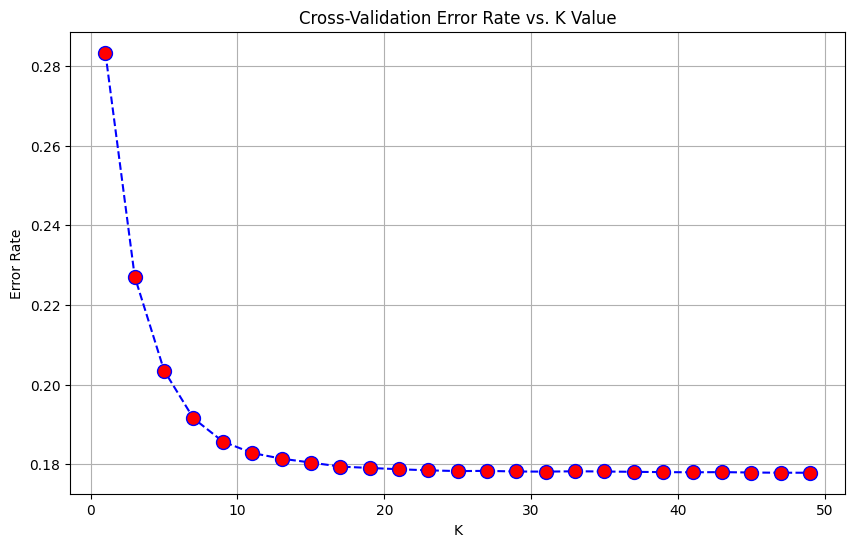

In [ ]:
# Plot the error rate vs. k
plt.figure(figsize=(10, 6))
plt.plot(kvals, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Cross-Validation Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

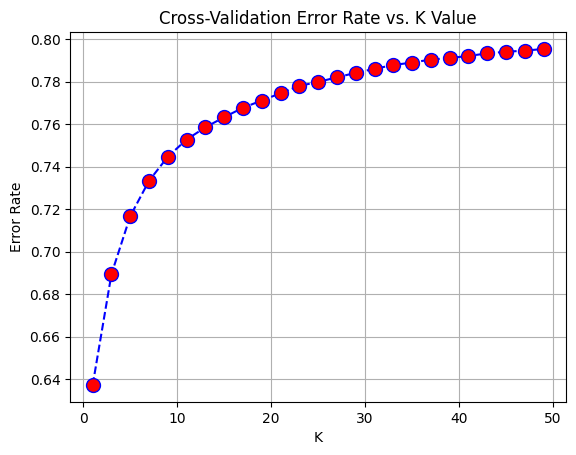

In [ ]:
#plot the k values and accuracies
plt.plot(kvals, accs, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Cross-Validation Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

In [ ]:
#Best k is k = 7
k = 7
knn_7 = KNeighborsClassifier(n_neighbors=k)
knn_7.fit(X_train, y_train)
y_pred_7 = knn_7.predict(X_test)


Accuracy:
0.8047834259888813
Precision:
0.823940170233865
Recall:
0.9698458246194251
F1 Score:
0.8909590510019436
Confusion Matrix: 


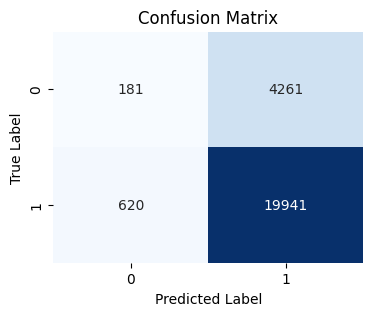

Final Report: 
              precision    recall  f1-score   support

           0       0.23      0.04      0.07      4442
           1       0.82      0.97      0.89     20561

    accuracy                           0.80     25003
   macro avg       0.52      0.51      0.48     25003
weighted avg       0.72      0.80      0.74     25003



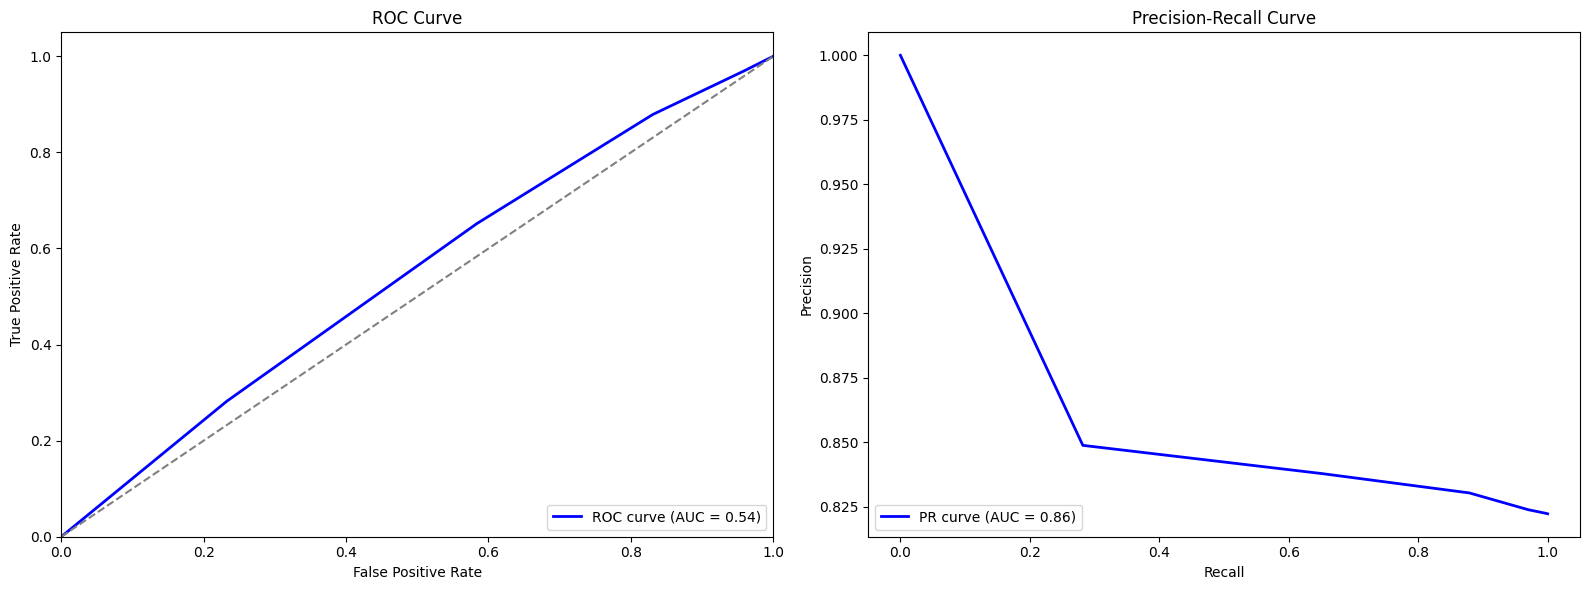


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('K Nearest Neighbours',knn_7, y_pred_7)

#Naive Bayes

In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('nb',  GaussianNB())  # Model step
])


# Define the parameter grid
param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],  # Example values for var_smoothing
    'nb__priors': [None, [0.2, 0.8], [0.3, 0.7], [0.1, 0.9]]  # Custom priors for imbalance
}

# Initialize GridSearchCV
nb_optimizer = GridSearchCV(
    pipeline,                 # Gaussian Naive Bayes classifier
    param_grid,                  # The parameter grid to search over
    cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,          # Use accuracy as the evaluation metric
    n_jobs=-1,                   # Use all available CPU cores
    verbose=2                    # Provide detailed output
)

# Fit the model
nb_optimizer.fit(X_train, y_train)

# Results
print("Best parameters found:", nb_optimizer.best_params_)
best_model_nb = nb_optimizer.best_estimator_

# Prediction on the test set
y_pred_nb = best_model_nb.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'nb__priors': None, 'nb__var_smoothing': 1e-06}


Accuracy:
0.6580810302763669
Precision:
0.8339635231316725
Recall:
0.7294392296094548
F1 Score:
0.7782072901803088
Confusion Matrix: 


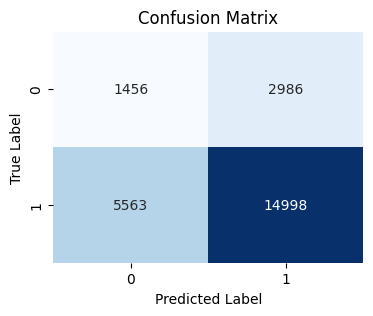

Final Report: 
              precision    recall  f1-score   support

           0       0.21      0.33      0.25      4442
           1       0.83      0.73      0.78     20561

    accuracy                           0.66     25003
   macro avg       0.52      0.53      0.52     25003
weighted avg       0.72      0.66      0.69     25003



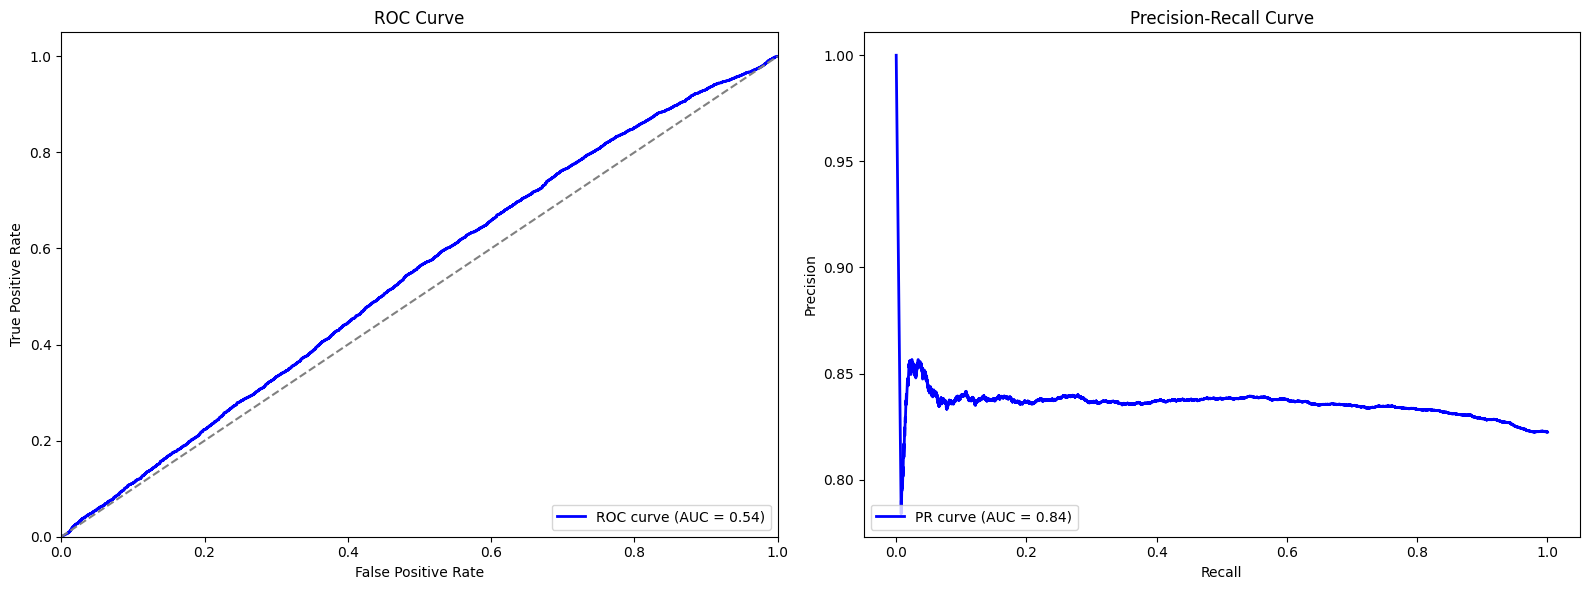


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('Naive Bayes',best_model_nb, y_pred_nb)

# Decision Tree

In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('dt', DecisionTreeClassifier(random_state=42, class_weight='balanced'))  # Model step
])

# Parameter space (note the 'dt__' prefix for pipeline parameters)
param_distributions = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': (5, 50),
    'dt__min_samples_split': (2, 30),
    'dt__min_samples_leaf': (1, 15),
    'dt__max_features': ['sqrt', 'log2', None],
    # Optional: You can also tune SMOTE parameters
    'smote__k_neighbors': (3, 10)
}

bayes_search_dt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_distributions,
    n_iter=20,
    cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

bayes_search_dt.fit(X_train, y_train)

print("Best parameters found:", bayes_search_dt.best_params_)
best_model_dt = bayes_search_dt.best_estimator_

y_pred_dt = best_model_dt.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy:
0.6727992640883094
Precision:
0.8341250134945482
Recall:
0.7515685034774573
F1 Score:
0.7906976744186046
Confusion Matrix: 


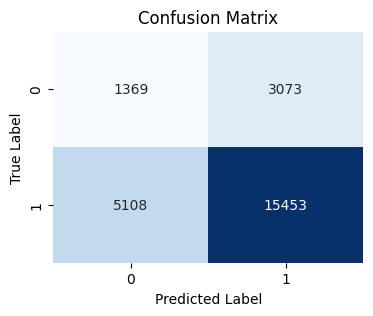

Final Report: 
              precision    recall  f1-score   support

           0       0.21      0.31      0.25      4442
           1       0.83      0.75      0.79     20561

    accuracy                           0.67     25003
   macro avg       0.52      0.53      0.52     25003
weighted avg       0.72      0.67      0.69     25003



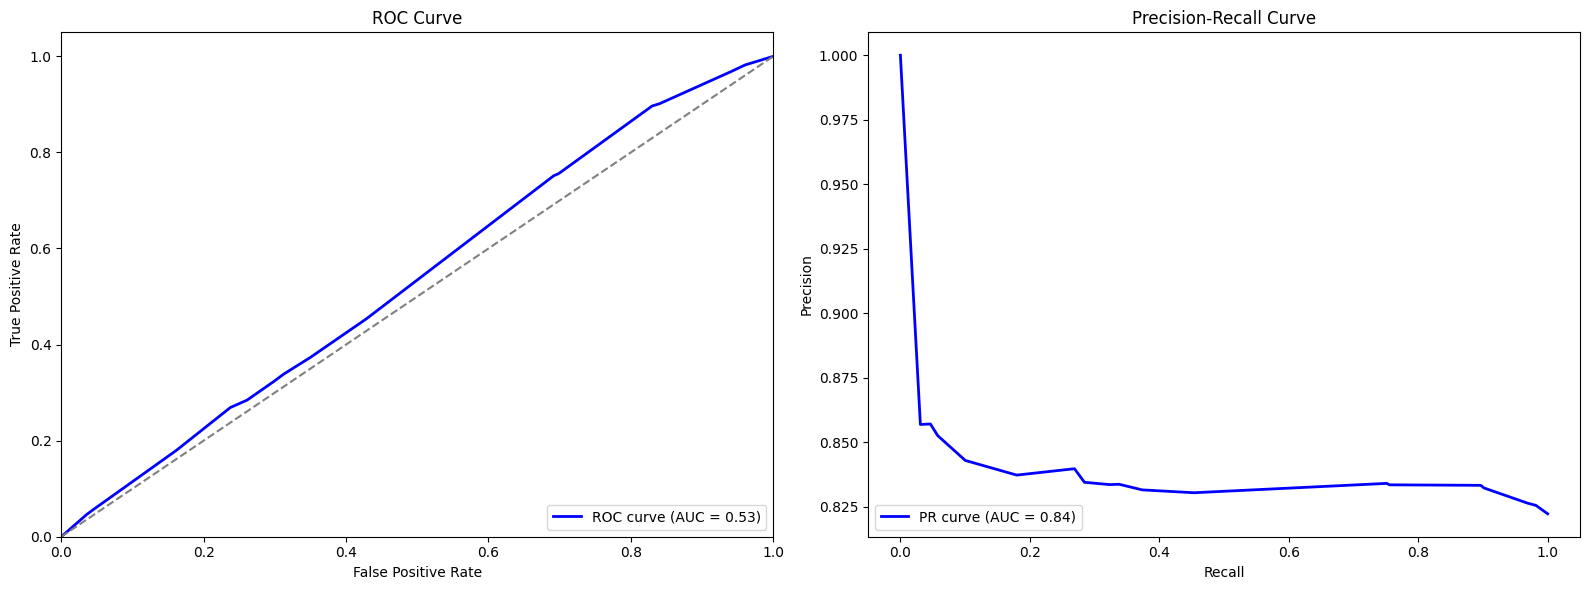


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('Decision Tree',best_model_dt, y_pred_dt)

#Logistic Regression

In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_space = {
    'C': (0.01, 10.0),                  # Regularization strength (inverse of regularization parameter)
    'solver': ['liblinear', 'saga'],     # Solvers to use for optimization
    'penalty': ['l2', 'l1'],             # Regularization type
    'max_iter': (100, 500),              # Maximum number of iterations for solver convergence
    'tol': (1e-5, 1e-2),                 # Tolerance for stopping criteria
}

log_reg = LogisticRegression(random_state=42)

bayes_search_lr = BayesSearchCV(
    log_reg,
    search_space,
    n_iter=20,                # Number of iterations for optimization
        cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,         # Scoring based on accuracy
    verbose=1,
    n_jobs=-1                 # Use all available processors
)

bayes_search_lr.fit(X_train, y_train)

print("Best parameters found:", bayes_search_lr.best_params_)
best_model_lr = bayes_search_lr.best_estimator_

y_pred_lr = best_model_lr.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy:
0.822341319041715
Precision:
0.8223928957158286
Recall:
0.9999027284665143
F1 Score:
0.9025021949078139
Confusion Matrix: 


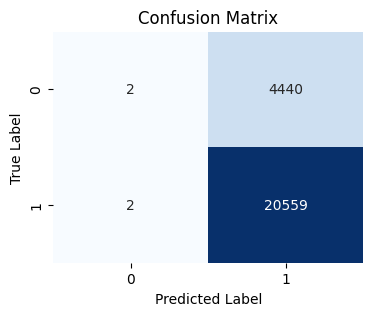

Final Report: 
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      4442
           1       0.82      1.00      0.90     20561

    accuracy                           0.82     25003
   macro avg       0.66      0.50      0.45     25003
weighted avg       0.77      0.82      0.74     25003



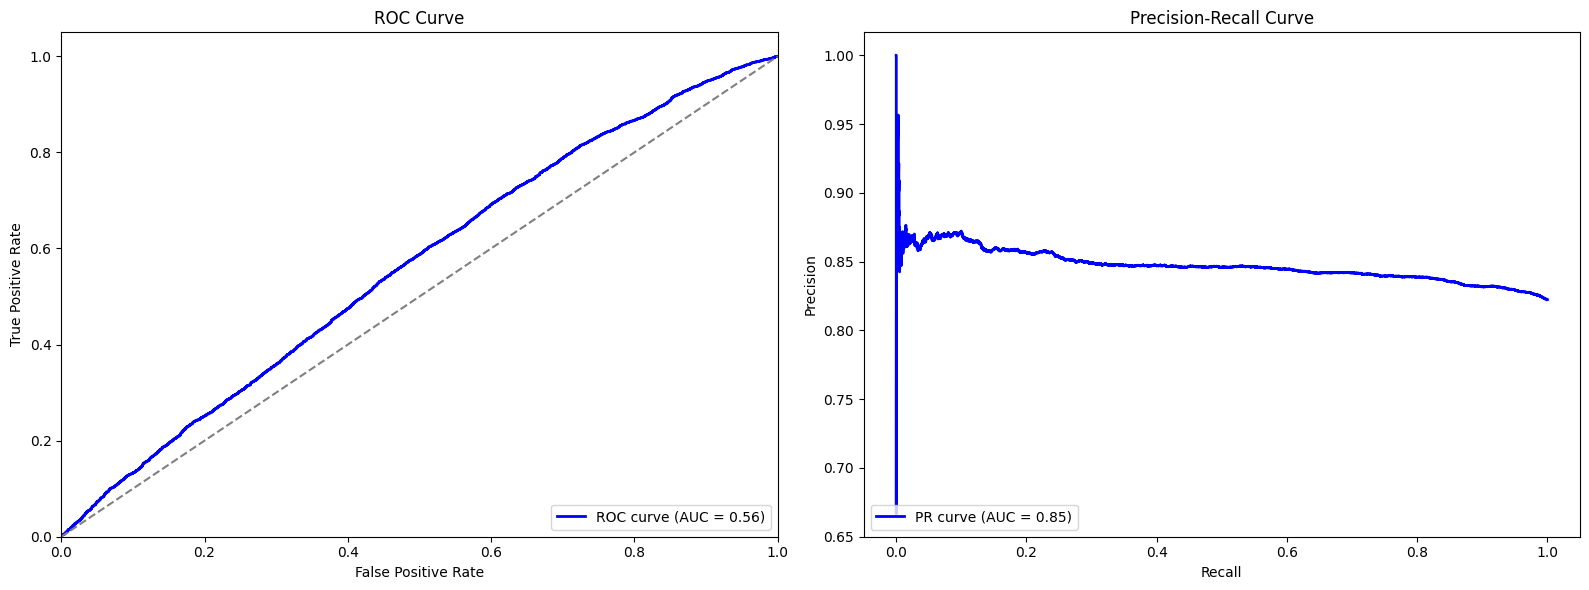


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('Logistic Regression',best_model_lr,y_pred_lr)

# XGBOOST

In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('xgb', xgb.XGBClassifier(objective='binary:logistic',  eval_metric='logloss', random_state=42,scale_pos_weight=0.216),)  # Model step
])

search_space = {
    'xgb__max_depth': (3, 10),                # Maximum depth of a tree
    'xgb__learning_rate': (0.01, 0.2),        # Learning rate
    'xgb__n_estimators': (50, 200),           # Number of boosting rounds
    'xgb__subsample': (0.6, 1.0),             # Fraction of samples for training
    'xgb__colsample_bytree': (0.6, 1.0),      # Fraction of features for each tree
    'xgb__gamma': (0, 0.2),                   # Minimum loss reduction required to make a further partition
    'xgb__reg_alpha': (0, 1),                 # L1 regularization term
    'xgb__reg_lambda': (0, 1),                # L2 regularization term
}

bayes_search_xgb = BayesSearchCV(
    pipeline,
    search_space,
    n_iter=20,  # Number of iterations for optimization
        cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,    # Scoring based on accuracy
    verbose=1
)

bayes_search_xgb.fit(X_train, y_train)

print("Best parameters found:", bayes_search_xgb.best_params_)
best_model_xgb = bayes_search_xgb.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy:
0.5240171179458465
Precision:
0.8640491003867496
Recall:
0.4998297748164
F1 Score:
0.6333076567555076
Confusion Matrix: 


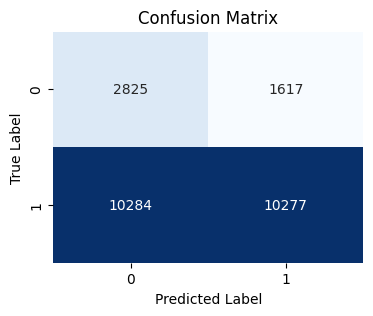

Final Report: 
              precision    recall  f1-score   support

           0       0.22      0.64      0.32      4442
           1       0.86      0.50      0.63     20561

    accuracy                           0.52     25003
   macro avg       0.54      0.57      0.48     25003
weighted avg       0.75      0.52      0.58     25003



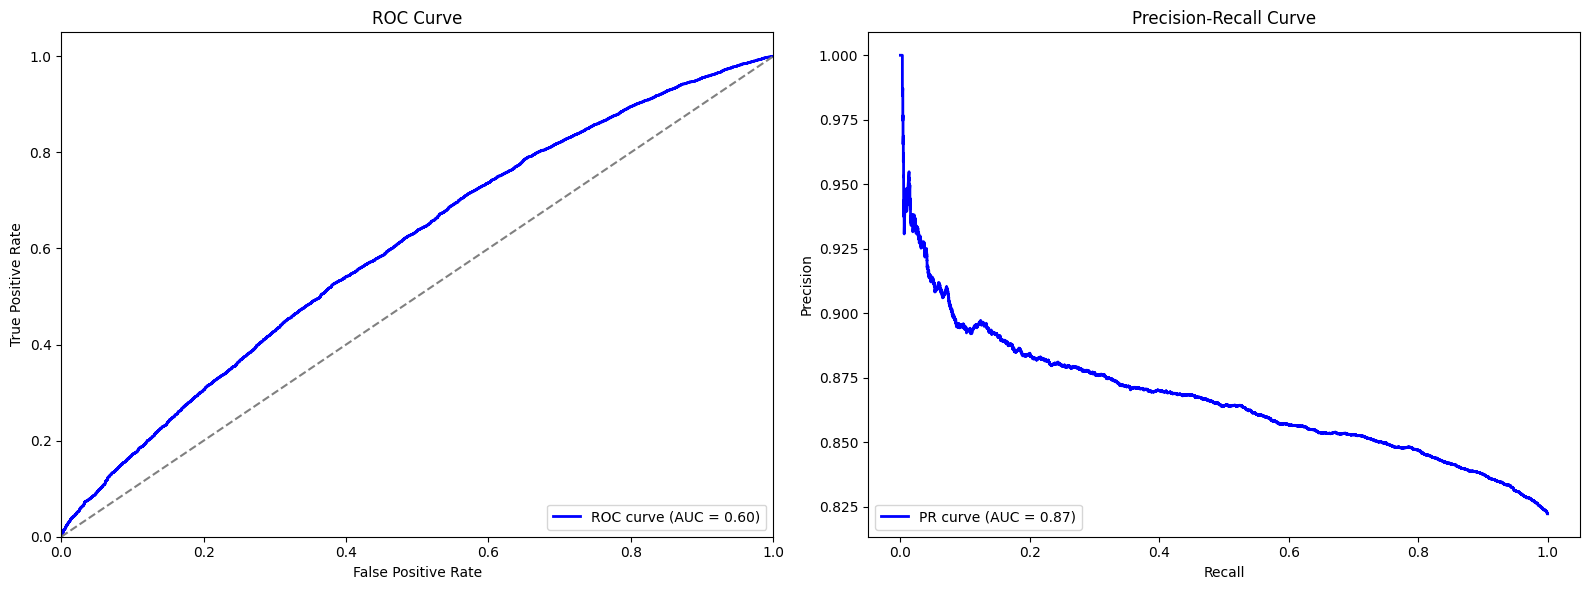


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('XGBoost',best_model_xgb, y_pred_xgb)

#AdaBoost

In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = AdaBoostClassifier(random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('ada', clf)  # Model step
])

search_space = {
    'ada__n_estimators': (50, 200),          # Number of estimators (trees)
    'ada__learning_rate': (0.01, 1.0),       # Learning rate
    'ada__estimator__max_depth': (3, 10),    # Base estimator's max_depth (for decision tree base estimators)
}

x = {
    'estimator': DecisionTreeClassifier(random_state=42),
    'estimator__max_depth': 5
}

clf.set_params(**x)

bayes_search_ada = BayesSearchCV(
    pipeline,
    search_space,
    n_iter=20,                # Number of iterations for optimization
    cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,        # Scoring based on accuracy
    verbose=1,
    n_jobs=-1                 # Use all available processors
)

bayes_search_ada.fit(X_train, y_train)

print("Best parameters found:", bayes_search_ada.best_params_)
best_model_ada = bayes_search_ada.best_estimator_

y_pred_ada = best_model_ada.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy:
0.7807463104427469
Precision:
0.8305493445569732
Recall:
0.921355965176791
F1 Score:
0.8735992621627854
Confusion Matrix: 


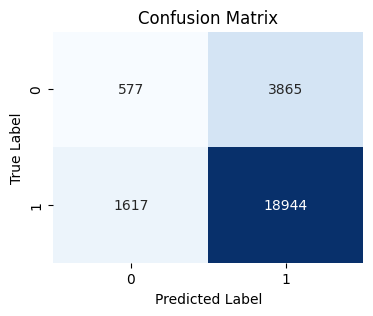

Final Report: 
              precision    recall  f1-score   support

           0       0.26      0.13      0.17      4442
           1       0.83      0.92      0.87     20561

    accuracy                           0.78     25003
   macro avg       0.55      0.53      0.52     25003
weighted avg       0.73      0.78      0.75     25003



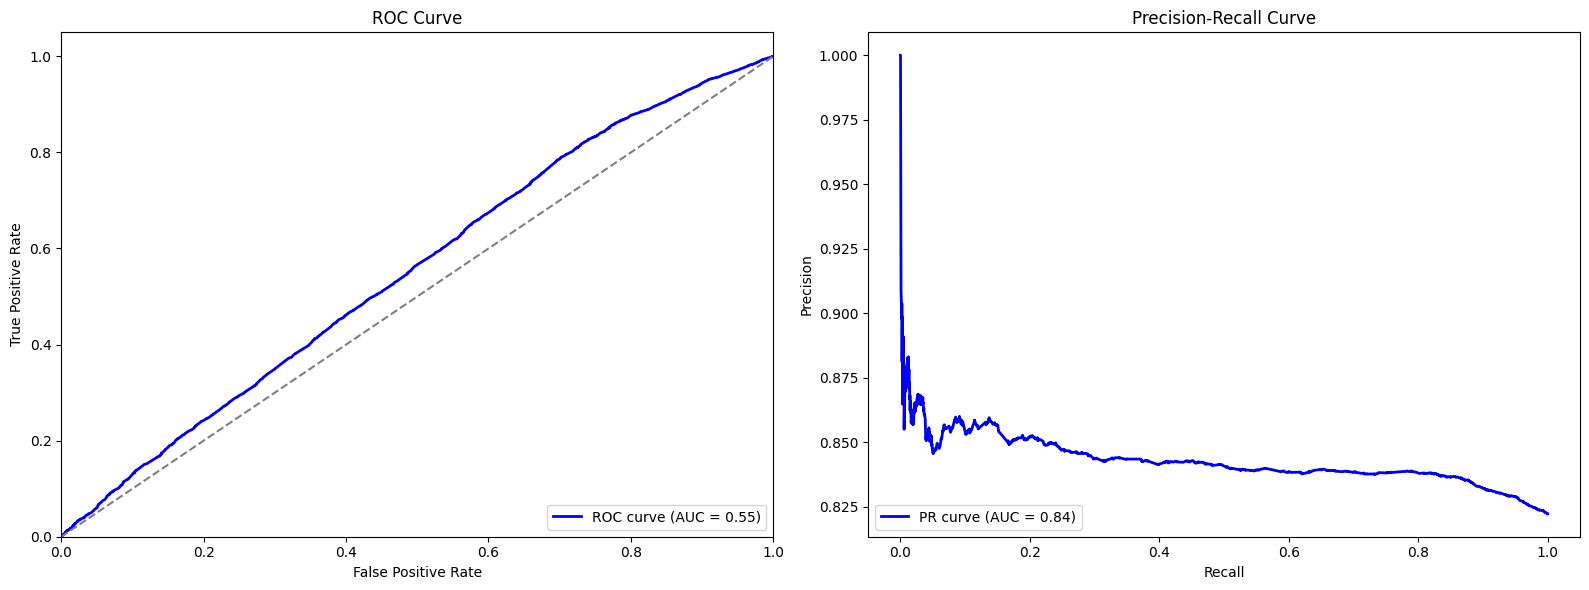


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('AdaBoost', best_model_ada,y_pred_ada)

#Random Forest


In [ ]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

# # Visualizing one of the trees
# i = 3
# tree = rf.estimators_[i]
# dot_data = export_graphviz(tree,
#                            feature_names=X_train.columns,
#                            filled=True,
#                            max_depth=2,
#                            impurity=False,
#                            proportion=True)
# graph = graphviz.Source(dot_data)
# display(graph)

# pd.Series(best_rf.feature_importances_, index=X.columns).plot.barh()
# print(f"Duplicate rows in X_train: {X_train.duplicated().sum()}")


In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Model step
])

param_distributions = {
    'rf__n_estimators': (50, 500),  # Number of trees in the forest
    'rf__max_depth': (1, 20),        # Max depth of the trees
    'rf__min_samples_split': (2, 20), # Minimum samples to split a node
    'rf__min_samples_leaf': (1, 20),  # Minimum samples at a leaf node
    'rf__max_features': ['sqrt', 'log2', None],
    # Optional: You can also tune SMOTE parameters
    # 'smote__k_neighbors': (3, 10)
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_distributions,
    n_iter=20,
    cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available cores
)


opt.fit(X_train, y_train)

print("Best parameters found:", opt.best_params_)
best_rf = opt.best_estimator_

y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy:
0.7635483741950966
Precision:
0.8342841495139428
Recall:
0.8890618160595302
F1 Score:
0.8608024110001884
Confusion Matrix: 


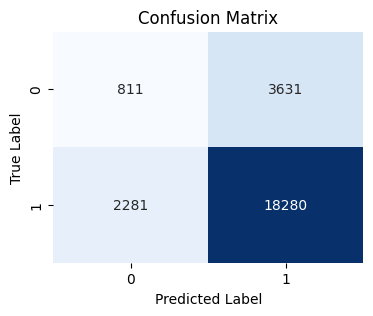

Final Report: 
              precision    recall  f1-score   support

           0       0.26      0.18      0.22      4442
           1       0.83      0.89      0.86     20561

    accuracy                           0.76     25003
   macro avg       0.55      0.54      0.54     25003
weighted avg       0.73      0.76      0.75     25003



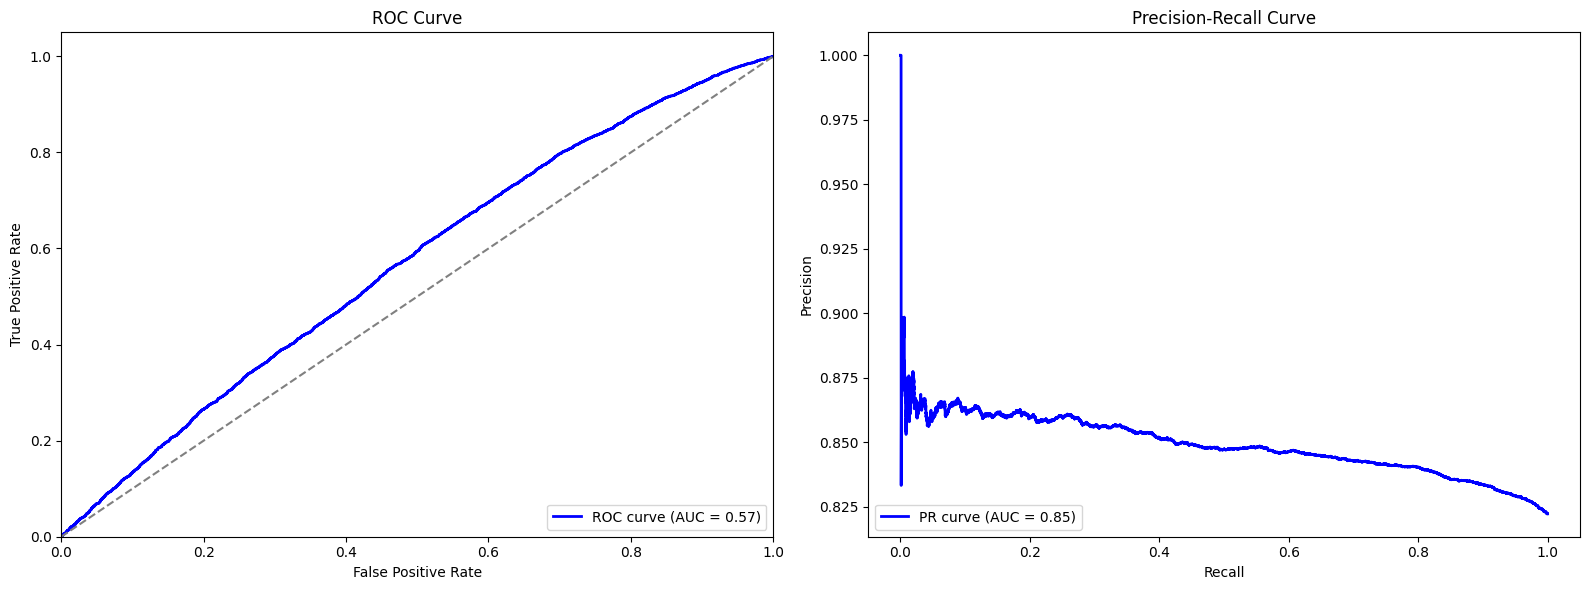


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('Random Forest',best_rf, y_pred_rf)

In [ ]:
df_metrics

NameError: name 'df_metrics' is not defined

#SVM


In [ ]:
# smote = SMOTE(random_state=42)
# mcc_scorer = make_scorer(matthews_corrcoef)
# stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# pipeline = ImbPipeline([
#     ('smote', smote),  # SMOTE step
#     ('svc',   SVC(kernel='linear', random_state=42))  # Model step
# ])

# param_space = {
#     'svc__C': Real(0.1, 100, prior='log-uniform'),
#     # 'svc__gamma': Real(0.001, 10, prior='log-uniform'),
#     # 'svc__kernel': Categorical(['linear', 'rbf']),
# }

# svm_optimizer = BayesSearchCV(
#     pipeline,                 # SVM classifier
#     param_space,           # The parameter space to search over
#     n_iter=20,             # Number of iterations to run
#     cv=stratified_k_fold,                        # 5-fold cross-validation
#     scoring=mcc_scorer,      # Use accuracy as the evaluation metric
#     n_jobs=-1,             # Use all available CPU cores
#     verbose=2              # Provide detailed output
# )

# svm_optimizer.fit(X_train, y_train)

# print("Best parameters found:", svm_optimizer.best_params_)
# best_model_svm = svm_optimizer.best_estimator_

# y_pred_svm = best_model_svm.predict(X_test)  # Prediction on the test set

# ADD rbf, polynomial and linear


In [ ]:
smote = SMOTE(random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),  # SMOTE step
    ('svc',   LinearSVCSVC(kernel='linear', random_state=42))  # Model step
])

param_space = {
    'svc__C': Real(0.1, 100, prior='log-uniform'),
    # 'svc__gamma': Real(0.001, 10, prior='log-uniform'),
    # 'svc__kernel': Categorical(['linear', 'rbf']),
}

svm_optimizer = BayesSearchCV(
    pipeline,                 # SVM classifier
    param_space,           # The parameter space to search over
    n_iter=20,             # Number of iterations to run
    cv=stratified_k_fold,                        # 5-fold cross-validation
    scoring=mcc_scorer,      # Use accuracy as the evaluation metric
    n_jobs=-1,             # Use all available CPU cores
    verbose=2              # Provide detailed output
)

svm_optimizer.fit(X_train, y_train)

print("Best parameters found:", svm_optimizer.best_params_)
best_model_svm = svm_optimizer.best_estimator_

y_pred_svm = best_model_svm.predict(X_test)  # Prediction on the test set



Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

Accuracy:
0.6034075910890693
Precision:
0.8328018508097292
Recall:
0.6477797772481884
F1 Score:
0.7287300979372983
Confusion Matrix: 


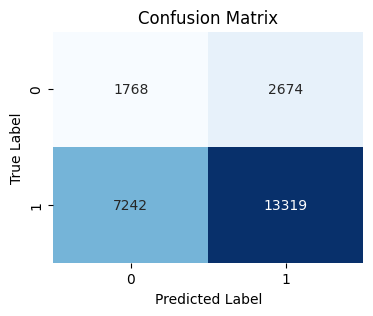

Final Report: 
              precision    recall  f1-score   support

           0       0.20      0.40      0.26      4442
           1       0.83      0.65      0.73     20561

    accuracy                           0.60     25003
   macro avg       0.51      0.52      0.50     25003
weighted avg       0.72      0.60      0.65     25003

brier score:  0.1460077050453239


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


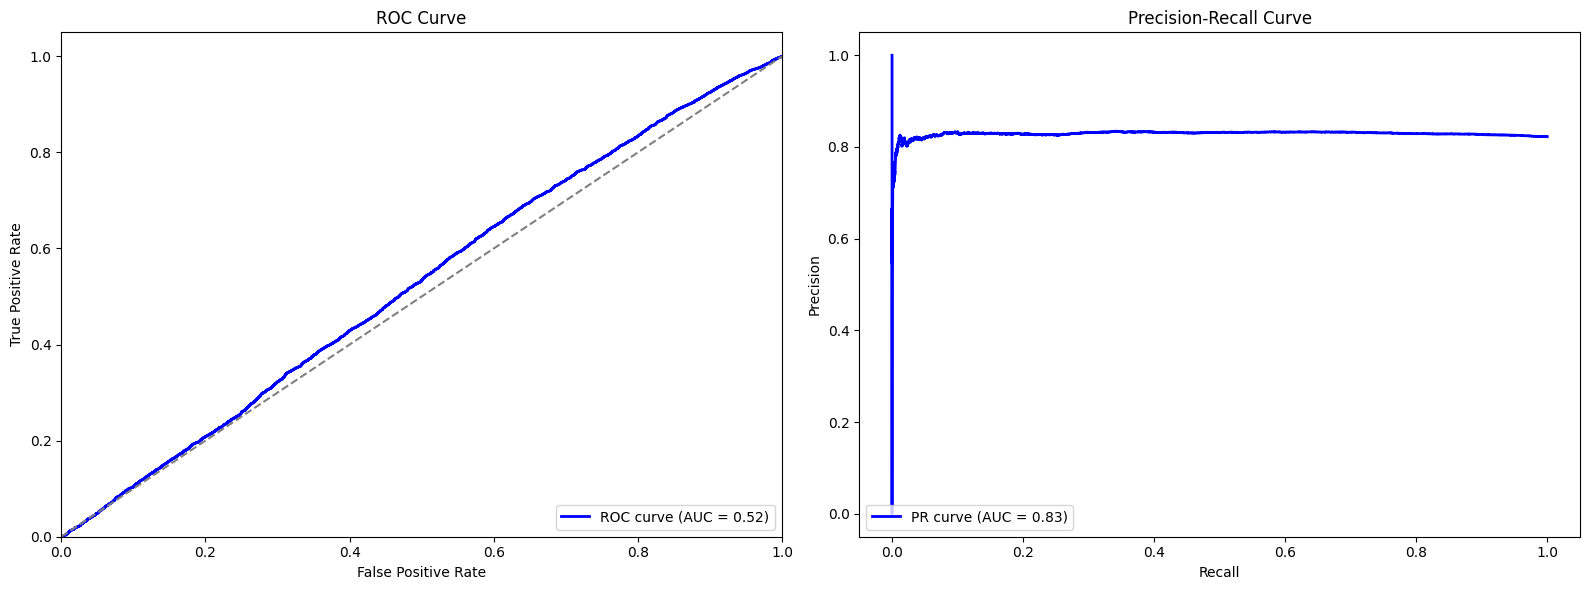


Updated Metrics DataFrame:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display_model_metrics('SVM', best_model_svm,y_pred_svm)

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, matthews_corrcoef, balanced_accuracy_score,
                           cohen_kappa_score, brier_score_loss, average_precision_score,
                           confusion_matrix)
import pandas as pd

# Load your data (replace with your actual data loading)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:


# Create and train SVM with RBF kernel using your best parameters
svm_model = SVC(
    C=0.1,
    gamma=0.001,
    kernel='rbf',
    random_state=42,
    probability=True
)

# Fit the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)
y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # For probability scores

# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)  # Same as sensitivity/TPR
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)  # Same as recall/TPR
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_pred_proba)
tpr = sensitivity  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
auc_pr = average_precision_score(y_test, y_pred_proba)  # AUC-PR

# Create a comprehensive results dataframe
results = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'TP', 'FP',
        'Sensitivity', 'Specificity', 'MCC', 'Balanced Accuracy',
        'Cohen\'s Kappa', 'Brier Score', 'TPR', 'FPR', 'AUC-PR'
    ],
    'Value': [
        accuracy, precision, recall_val, f1, auc, tp, fp,
        sensitivity, specificity, mcc, balanced_accuracy,
        kappa, brier_score, tpr, fpr, auc_pr
    ]
})

# Format the values for better readability
results['Formatted'] = results['Value'].apply(lambda x: f'{x:.4f}' if isinstance(x, (int, float)) else str(x))

# Print the comprehensive results
print("=" * 60)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 60)
print(results[['Metric', 'Formatted']].to_string(index=False))
print("=" * 60)

# Print detailed confusion matrix info
print(f"\nConfusion Matrix Details:")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Print classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Save results to CSV
results.to_csv('svm_rbf_comprehensive_metrics.csv', index=False)
print(f"\nResults saved to 'svm_rbf_comprehensive_metrics.csv'")


COMPREHENSIVE MODEL EVALUATION METRICS
           Metric  Formatted
         Accuracy     0.8223
        Precision     0.8223
           Recall     1.0000
         F1 Score     0.9025
              AUC     0.4772
               TP 20561.0000
               FP  4442.0000
      Sensitivity     1.0000
      Specificity     0.0000
              MCC     0.0000
Balanced Accuracy     0.5000
    Cohen's Kappa     0.0000
      Brier Score     0.1461
              TPR     1.0000
              FPR     1.0000
           AUC-PR     0.8069

Confusion Matrix Details:
True Positives (TP): 20561
False Positives (FP): 4442
True Negatives (TN): 0
False Negatives (FN): 0

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4442
           1       0.82      1.00      0.90     20561

    accuracy                           0.82     25003
   macro avg       0.41      0.50      0.45     25003
weighted avg       0.68      0.82      0.74 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
'''
param_space_linear = {
    'C': Real(0.1, 50, prior='log-uniform'),  # Only 'C' for linear kernel
    'kernel': Categorical(['linear'])  # Only 'linear' kernel
}

param_space_rbf = {
    'C': Real(0.1, 50, prior='log-uniform'),  # 'C' for rbf kernel
    'gamma': Real(0.01, 1, prior='log-uniform'),  # 'gamma' for rbf kernel
    'kernel': Categorical(['rbf'])  # Only 'rbf' kernel
}

param_space_poly = {
    'C': Real(0.1, 50, prior='log-uniform'),  # 'C' for rbf kernel
    'gamma': Real(0.01, 1, prior='log-uniform'),  # 'gamma' for rbf kernel
    'kernel': Categorical(['poly'])  # Only 'poly' kernel
}

# Function to run BayesSearchCV for a specific kernel and param space
def optimize_svm(param_space):
    # Perform Bayesian optimization with the given param_space
    svm_optimizer = BayesSearchCV(
        SVC(),                 # SVM classifier
        param_space,           # The parameter space to search over
        n_iter=5,             # Number of iterations to run
        cv=stratified_k_fold,                        # 5-fold cross-validation
        scoring=mcc_scorer,   # Use accuracy as the evaluation metric
        n_jobs=-1,             # Use all available CPU cores
        verbose=2              # Provide detailed output
    )

    # Fit the model and find the best parameters
    svm_optimizer.fit(X_train, y_train)

    # Print and return the best parameters and model
    return svm_optimizer.best_estimator_

# Optimize for each kernel type separately
best_model_svm_linear = optimize_svm(param_space_linear)
best_model_svm_rbf = optimize_svm(param_space_rbf)
best_model_svm_poly = optimize_svm(param_space_poly)

# Predictions on the test set using the best model from each kernel type
y_pred_svm_linear = best_model_svm_linear.predict(X_test)
y_pred_svm_rbf = best_model_svm_rbf.predict(X_test)
y_pred_svm_poly = best_model_svm_poly.predict(X_test)

# Evaluate the accuracy for each model
accuracy_linear = accuracy_score(y_test, y_pred_svm_linear)
accuracy_rbf = accuracy_score(y_test, y_pred_svm_rbf)
accuracy_poly = accuracy_score(y_test, y_pred_svm_poly)

# Print accuracy results for each kernel
print(f"Accuracy for Linear Kernel: {accuracy_linear}")
print(f"Accuracy for RBF Kernel: {accuracy_rbf}")
print(f"Accuracy for Poly Kernel: {accuracy_poly}")
'''

#Random Survival Forest

In [ ]:
df_rsf = pd.read_csv('dfencoded_rsf.csv')
df_rsf.dropna(inplace=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV

# Assuming df_rsf is your DataFrame containing the survival data
# Drop the target columns to create features (X)
X_rsf = df_rsf.drop(columns=['Survival months', 'Survived', 'Survival months flag'])

# Create survival structured array for the target (y)
# Note: Surv.from_dataframe expects 'event' first, then 'time'
y_rsf = Surv.from_dataframe('Survived', 'Survival months', df_rsf)


# Create Matthews Correlation Coefficient scorer
mcc_scorer = make_scorer(matthews_corrcoef)

# Create stratified k-fold cross-validator
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split data into train and test sets
# Note: For survival analysis, we typically don't use stratification on y
# since it's a structured array. We'll stratify on the event indicator instead.
X_train_rsf, X_test_rsf, y_train_rsf, y_test_rsf = train_test_split(
    X_rsf,
    y_rsf,
    test_size=0.3,
    random_state=42,
    stratify=df_rsf['Survived']  # Stratify on the event indicator
)

# Define the search space for Bayesian optimization
search_space = {
    'n_estimators': (50, 200),              # Number of trees (estimators)
    'max_depth': (3, 10),                   # Maximum depth of the trees
    'min_samples_split': (2, 10),           # Minimum samples required to split a node
    'min_samples_leaf': (1, 10),            # Minimum samples required at a leaf node
    'max_features': (0.1, 1.0),             # Fraction of features to use in each tree
}

# Initialize the Random Survival Forest model
rsf_model = RandomSurvivalForest(class_weight='balanced',random_state=42)

# Initialize Bayesian search
bayes_search_rsf = BayesSearchCV(
    rsf_model,
    search_space,
    n_iter=20,                  # Number of iterations for optimization
    cv=5,       # 5-fold cross-validation
    scoring=mcc_scorer,         # Use MCC scorer (fixed from None)
    verbose=1,
    n_jobs=-1                   # Use all processors for faster computation
)

# Fit the model
bayes_search_rsf.fit(X_train_rsf, y_train_rsf)

# Print results
print("Best parameters found:", bayes_search_rsf.best_params_)
best_model_rsf = bayes_search_rsf.best_estimator_


In [ ]:
y_pred_rsf = best_model_rsf.predict(X_test_rsf)

In [ ]:
c_index = concordance_index_censored(yrsfdf['Survived'], yrsfdf['Survival months'], y_pred_rsf)
print(f"C-index: {c_index[0]:.4f}")

In [ ]:
predicted_survival = y_pred_rsf  # Median survival probabilities

brier_score = np.mean((predicted_survival - yrsfdf['Survival months']) ** 2)
print(f"Brier Score: {brier_score:.4f}")

kmf = KaplanMeierFitter()

high_risk = y_pred_rsf < np.median(y_pred_rsf)
kmf.fit(y_test_rsf['Survival months'][high_risk], event_observed=y_test_rsf['Survived'][high_risk], label="High Risk")
kmf.plot()

low_risk = ~high_risk
kmf.fit(y_test_rsf['Survival months'][low_risk], event_observed=y_test_rsf['Survived'][low_risk], label="Low Risk")
kmf.plot()

plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Survival Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()